In [1]:
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
import rdkit.Chem.QED as QED
from rdkit import rdBase

rdBase.DisableLog("rdApp.error")
from rdkit.Chem import rdMolDescriptors
from rdkit.six import iteritems

import sys
import logging
import pandas as pd

In [54]:
file_names = ["out_1000_train_experiment.csv","out_50_train_experiment.csv","out_400_train_experiment.csv",
             "out_200_train_experiment.csv","out_100_train_experiment.csv","out_10_train_experiment.csv"]

In [43]:
# checking all columns are the same:
def colsdf(file_path):
    df = pd.read_csv(f'Downloads/{file_path}')
    return df.columns
for i in file_names:
    print(colsdf(i))

Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')
Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')
Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')
Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')
Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')
Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')
Index(['Real Response', 'Mod

In [44]:
df.columns

Index(['Real Response', 'Model Response', 'top_0', 'top_1', 'top_2', 'top_3',
       'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9'],
      dtype='object')

In [2]:
def setup_logger():
    logger = logging.getLogger("eval_contam")
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(module)s - %(message)s")
    sh = logging.StreamHandler(sys.stdout)
    sh.setFormatter(formatter)

    logger.addHandler(sh)
    return logger

logger = setup_logger()


def similarity(smiles_a, smiles_b):
    """Evaluate Tanimoto similarity between 2 SMILES strings

    Args:
      smiles_a: str, SMILES string
      smiles_b: str, SMILES string

    Returns:
      similarity score: float, between 0 and 1.

    """
    if smiles_a is None or smiles_b is None:
        return 0.0
    amol = Chem.MolFromSmiles(smiles_a)
    bmol = Chem.MolFromSmiles(smiles_b)
    if amol is None or bmol is None:
        return 0.0
    fp1 = AllChem.GetMorganFingerprintAsBitVect(amol, 2, nBits=2048, useChirality=False)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(bmol, 2, nBits=2048, useChirality=False)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def score_against_known_drugs(smiles_query, smiles_list):
    """Evaluate if a given SMILES string is close to a known list of SMILES strings
    Args:
      smiles_query: str, SMILES string
      smiles_list: list of str, SMILES strings
      
      Returns:
      similarity score: float, between 0 and 1.
      
    """
    similarity_list = []
    for smi in smiles_list:
        similarity_list.append(similarity(smi, smiles_query))
    return max(similarity_list)

In [27]:
def similarity_total(filepath, col1, col2):
    """
    takes a csv filepath string
    turns it to df. 
    gets the headers of 2 columns to compare.
    compares the strings in the two columns.
    returns different statistics.
    """
    df = pd.read_csv(filepath)
    # df['similarity_column'] = df.apply(similarity, axis=1)
    similarity_vals = []
    cols = df.columns
    # print(df)
    for index, row in df.iterrows():
        # print("Here")
        SMILE1 = row[col1]
        # print(SMILE1, type(SMILE1))
        SMILE2 = row[col2]
        # print(SMILE2, type(SMILE2))
        if not isinstance(SMILE1, str) or not isinstance(SMILE2, str):
            similarity_vals.append(None)
        else:
            similarity_vals.append(similarity(SMILE1, SMILE2))

    df['similarity_column'] = similarity_vals
    #getting stats
    average_value = df['similarity_column'].mean()
    max_value = df['similarity_column'].max()
    min_value = df['similarity_column'].min()

    stats = {"Mean" : average_value, "Max": max_value, "Min": min_value}

    return stats

In [28]:
df = pd.read_csv("out_50_train_experiment.csv")
# type(df["top_0"][10]) == 
df["Real Response"][10]

'CCCCCC(C=CC1C(CC(=O)C1CCCCCCC(=O)O)O)O'

In [31]:
# mean on model response, 
# mean top 1 on GraphGA, 
# mean top 5 GraphGA, 
# mean top 10 GraphGA
file_names = ["out_1000_train_experiment.csv","out_50_train_experiment.csv","out_400_train_experiment.csv",
             "out_200_train_experiment.csv","out_100_train_experiment.csv","out_10_train_experiment.csv"]
titles =[]
Model_similarity =[]
GraphGA_1st_similarity=[]
GraphGA_5st_similarity =[] 
GraphGA_10st_similarity= []

for file in file_names:
    title = file.strip("out_").split("_")[0]
    titles.append(title)
    filepath = file
    df = pd.read_csv(filepath)
    mean_model = similarity_total(filepath, "Real Response", "Model Response")["Mean"]
    Model_similarity.append(mean_model)
    mean_first = similarity_total(filepath, "Real Response", "top_0")["Mean"]
    GraphGA_1st_similarity.append(mean_first)
    mean_fifth = similarity_total(filepath, "Real Response", "top_4")["Mean"]
    GraphGA_5st_similarity.append(mean_fifth)
    mean_ten = similarity_total(filepath, "Real Response", "top_9")["Mean"]
    GraphGA_10st_similarity.append(mean_ten)
    print(f'trained on {title}. Similarity mean of the model and actual response of {mean_model}, Similarity mean of the model and top 1 GraphGA of {mean_first}, \n Similarity mean of the model and top 5 GraphGA of {mean_fifth}, Similarity mean of the model and top 10 GraphGA of {mean_ten}')
    
    

[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not r

trained on 1000. Similarity mean of the model and actual response of 0.11609562654938131, Similarity mean of the model and top 1 GraphGA of 0.10905928948763206, 
 Similarity mean of the model and top 5 GraphGA of 0.10590331036652197, Similarity mean of the model and top 10 GraphGA of 0.10522491235604123


[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] Conflicting single bond directions around double bond at index 18.
[14:35:13]   BondStereo set to STEREONONE and single bond directions set to NONE.


trained on 50. Similarity mean of the model and actual response of 0.09341608946183738, Similarity mean of the model and top 1 GraphGA of 0.10307340163262027, 
 Similarity mean of the model and top 5 GraphGA of 0.10173183316011163, Similarity mean of the model and top 10 GraphGA of 0.09589916512537361


[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not r

trained on 400. Similarity mean of the model and actual response of 0.12427416501914836, Similarity mean of the model and top 1 GraphGA of 0.10627960314702341, 
 Similarity mean of the model and top 5 GraphGA of 0.10798887204763791, Similarity mean of the model and top 10 GraphGA of 0.10958080936355075


[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:13] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not r

trained on 200. Similarity mean of the model and actual response of 0.12827311677862246, Similarity mean of the model and top 1 GraphGA of 0.09635949331903744, 
 Similarity mean of the model and top 5 GraphGA of 0.10099918365331154, Similarity mean of the model and top 10 GraphGA of 0.10367696090956566


[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not r

trained on 100. Similarity mean of the model and actual response of 0.09970870606305736, Similarity mean of the model and top 1 GraphGA of 0.09753649148883031, 
 Similarity mean of the model and top 5 GraphGA of 0.10159342951915169, Similarity mean of the model and top 10 GraphGA of 0.09571762676000828
trained on 10. Similarity mean of the model and actual response of 0.09424888216863986, Similarity mean of the model and top 1 GraphGA of 0.09514923120479002, 
 Similarity mean of the model and top 5 GraphGA of 0.09498125676649133, Similarity mean of the model and top 10 GraphGA of 0.09521304505460998


[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors
[14:35:14] WARNING: not removing hydrogen atom without neighbors


In [29]:
file_path = '
.csv'
a = similarity_total(file_path)
a

{'Mean ': 0.09119284461305036, 'Max': 0.3373493975903614, 'Min': 0.0}

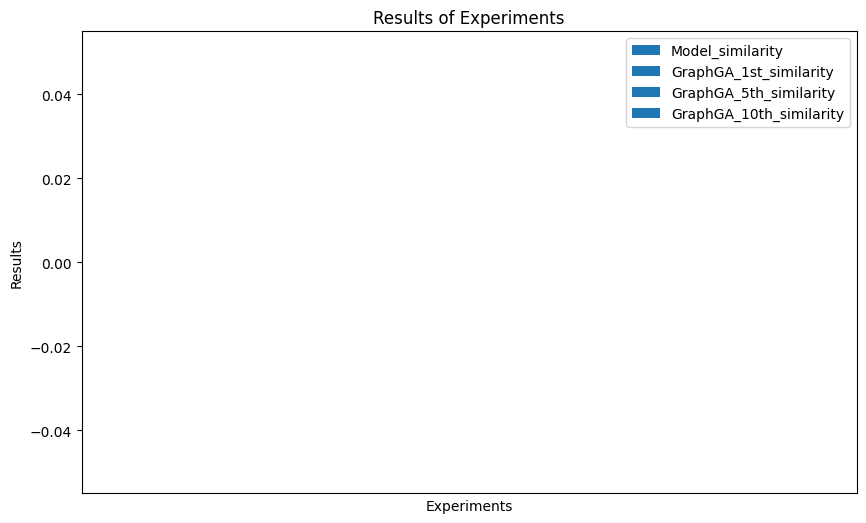

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

titles =[]
Model_similarity =[]
GraphGA_1st_similarity=[]
GraphGA_5st_similarity =[] 
GraphGA_10st_similarity= []

# Example DataFrame with experiment results
data = {
    'Experiment': titles,
    'Model_similarity': Model_similarity,
    'GraphGA_1st_similarity': GraphGA_1st_similarity,
    'GraphGA_5th_similarity': GraphGA_5st_similarity,
    'GraphGA_10th_similarity': GraphGA_10st_similarity
}

df = pd.DataFrame(data)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.2

# Position of each group of bars
bar_positions = range(len(df['Experiment']))

# Plot bars for each result
ax.bar([pos - 1.5 * bar_width for pos in bar_positions], df['Model_similarity'], width=bar_width, label='Model_similarity')
ax.bar([pos - 0.5 * bar_width for pos in bar_positions], df['GraphGA_1st_similarity'], width=bar_width, label='GraphGA_1st_similarity')
ax.bar([pos + 0.5 * bar_width for pos in bar_positions], df['GraphGA_5th_similarity'], width=bar_width, label='GraphGA_5th_similarity')
ax.bar([pos + 1.5 * bar_width for pos in bar_positions], df['GraphGA_10th_similarity'], width=bar_width, label='GraphGA_10th_similarity')

# Set labels and title
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['Experiment'])
ax.set_xlabel('Experiments')
ax.set_ylabel('Results')
ax.set_title('Results of Experiments')

# Add legend
ax.legend()

# Show the plot
plt.show()